# Mushroom edibility classification


**Student number: 23381200**
**Date: 2025-01-16**

Artificial Intelligence tools used in this assignment:
- Google Gemini as a coding assistant
- Perplexity AI Model as a research tool

# A. Background


Mushrooms are a global dietary staple, valued for their low calorie and high nutrient content. A 2023 systematic review by De Cianni *et al.* highlights their umami flavour and potential as a plant-based protein alternative due to their texture and high-quality protein. However, the review notes the prevalence of mycophobia in some regions, driven somewhat by fears of poisoning.

These fungi go beyond their culinary role as they emerge as powerful nutraceuticals, offering therapeutic potential in modern healthcare. A comprehensive analysis of fungal nutraceutical constituents conducted by Ma *et al.* (2018) demonstrated that mushrooms possess a diverse array of bioactive molecules including polysaccharides, proteins, glycoproteins, unsaturated fatty acids, phenolic compounds, tocopherols, ergosterols and lectins. This biochemical profile, coupled with their favorable nutritional composition positions mushrooms as potential therapeutic agents in preventive medicine.

In Europe, for example, only 60 of the 269 edible mushroom taxa suitable for marketing are commercially cultivated, with the majority being wild varieties which if misidentified can have serious consequences. Thus mechanisms that enable the safe commercialisation of wild mushrooms are needed.

Machine learning can be leveraged as a tool for the safe commercialisation of wild mushrooms in an industry set to grow from 18.39 million USD (US Dollar) in 2024 to 32.04 million USD by 2032 (Fortune Business Insights, 2024) by enabling accurate and robust classification of edible versus poisonous (or potentially poisonous) mushrooms.

The objective of this project is to showcase 2 machine learning methods that have the potential to lead to the accurate classification of mushrooms. First an ensemble learning method showing the potential for classification based on tabular data. Second a deep learning method showcasing classification based on labelled images.

# B. Methods

## 1. Data description


The UC Irvine Machine Learning Repository provided the tabular dataset for this project (Wagner *et al.*, 2021a). This hypothetical mushroom dataset based on the 3rd edition of the book guide *Mushrooms and Toadstools* comprises 61069 theoretical capped mushrooms, representing 173 species with 353 mushrooms per species.

Kaggle provided the database of imagery for this project (Kuno-Williams, 2022), these can be accessed via https://www.kaggle.com/datasets/derekkunowilliams/mushrooms/data. It contains 8781 jpg files of mushrooms representing 261 species gathered from Google. The mushrooms are classified as 'conditionally_edible', 'deadly', 'edible' and 'poisonous'. For the purpose of this assignment only the 'edible' and 'poisonous' images are considered.






## 2. Model selection


Firstly the possibility of classifying mushroom edibility based on tabular data is explored by training a random forest model.This type of algorithm provides a more stable and accurate prediction compared to linear discriminant analysis, naive bayes and logistic regression (Wagner et al. 2021b) and is very flexible as it does not have any formal assumptions about the distribution. The RF builds a multiple decision trees which are combined to provide the prediction (Wagner *et al.*, 2021b).


Second the potential for mushroom classification based on images using a convolutional neural network (CNN) was explored as these are commonly used for solving classification problems (Rawat et al., 2017). A basic CNN was built and different hyperparameter tuning was applied to get to the best model and evaluate its potential for mushroom classification. Then transfer learning was performed using the MobileNet2 model as the base with the imagenet weights applied to the model to leverage the model's existing capacity for image classification.

In [ ]:
# For simplicity, we will use the gitpython library to clone the repository to the local machine.
# Clone the GitHub repository on the local machine
!pip install gitpython
import git
from git import Repo

Repo.clone_from("https://github.com/LientjieColahan/C7082_23381200.git", to_path="C:/Users/colah/OneDrive/Desktop/Clone")
 


## 3. Random Forest Classifier training

### Methods

#### Data import and wrangling

The following code chunk downloads the necessary resources for data processing, model training, evaluation and visualisation in this assignment.

In [5]:
# Import the necessary libraries

import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from joblib import dump, load
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense
!pip install torchvision
from torchvision import transforms
import keras
from keras import layers
from tensorflow import data as tf_data
import shutil
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

The training dataset can be found in the GitHub repository under Model_training as '*secondary_mushroom_data.csv*' and the following code chunk imports the data directly from the raw data link from GitHub and separates the target variables, edible (e) or poisonous (p) from the features as well as doing manual data type conversions to ensure the data is in the correct format.

In [47]:
# URL of the raw CSV file in the GitHub repository
url = "https://raw.githubusercontent.com/LientjieColahan/C7082_23381200/refs/heads/main/Model_training/secondary_mushroom_data.csv"

# Load the database
data = pd.read_csv(url, delimiter=';')
# Separate features and target
X = data.drop('class', axis=1)  # Features
y = data['class']  # Target variable

# Convert categorical variables to categorical data type
categorical_columns = X.select_dtypes(include=['object']).columns
X[categorical_columns] = X[categorical_columns].astype('category')

# Convert target variable to categorical
y = y.astype('category')

# Convert continuous variables to float
continuous_columns = ['cap-diameter', 'stem-height', 'stem-width']
X[continuous_columns] = X[continuous_columns].astype(float)

#### Exploratory data analysis

Before training a model it is good practice to do some basic data analysis to make sure the data is suitable for model training. The code below gives an overview of the dataset and shows how many missing values there are for each feature.

In [48]:
# Display basic information about the dataset
print("\nFirst few rows of the features:")
print(X.head())
print("\nFirst few rows of the target:")
print(y.head())

# Check for missing values
print("\nMissing values in the dataset:")
missing_values = X.isnull().sum()
missing_percentages = (100 * X.isnull().sum() / len(X)).round(2)
missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Count', 'Percentage'])
missing_table = missing_table[missing_table['Count'] > 0].sort_values('Percentage', ascending=False)
print(missing_table)


First few rows of the features:
   cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0         15.26         x           g         o                    f   
1         16.60         x           g         o                    f   
2         14.07         x           g         o                    f   
3         14.17         f           h         e                    f   
4         14.64         x           h         o                    f   

  gill-attachment gill-spacing gill-color  stem-height  stem-width stem-root  \
0               e          NaN          w        16.95       17.09         s   
1               e          NaN          w        17.99       18.19         s   
2               e          NaN          w        17.80       17.74         s   
3               e          NaN          w        15.77       15.98         s   
4               e          NaN          w        16.53       17.20         s   

  stem-surface stem-color veil-type veil-color has-ri

Determining if there are any features that relate to only one of the target variables is important as these types of features may cause bias in the training data making the model less generalisable. The following code chunk visualises the relationship between the categorical features and the target variables in bar plots.

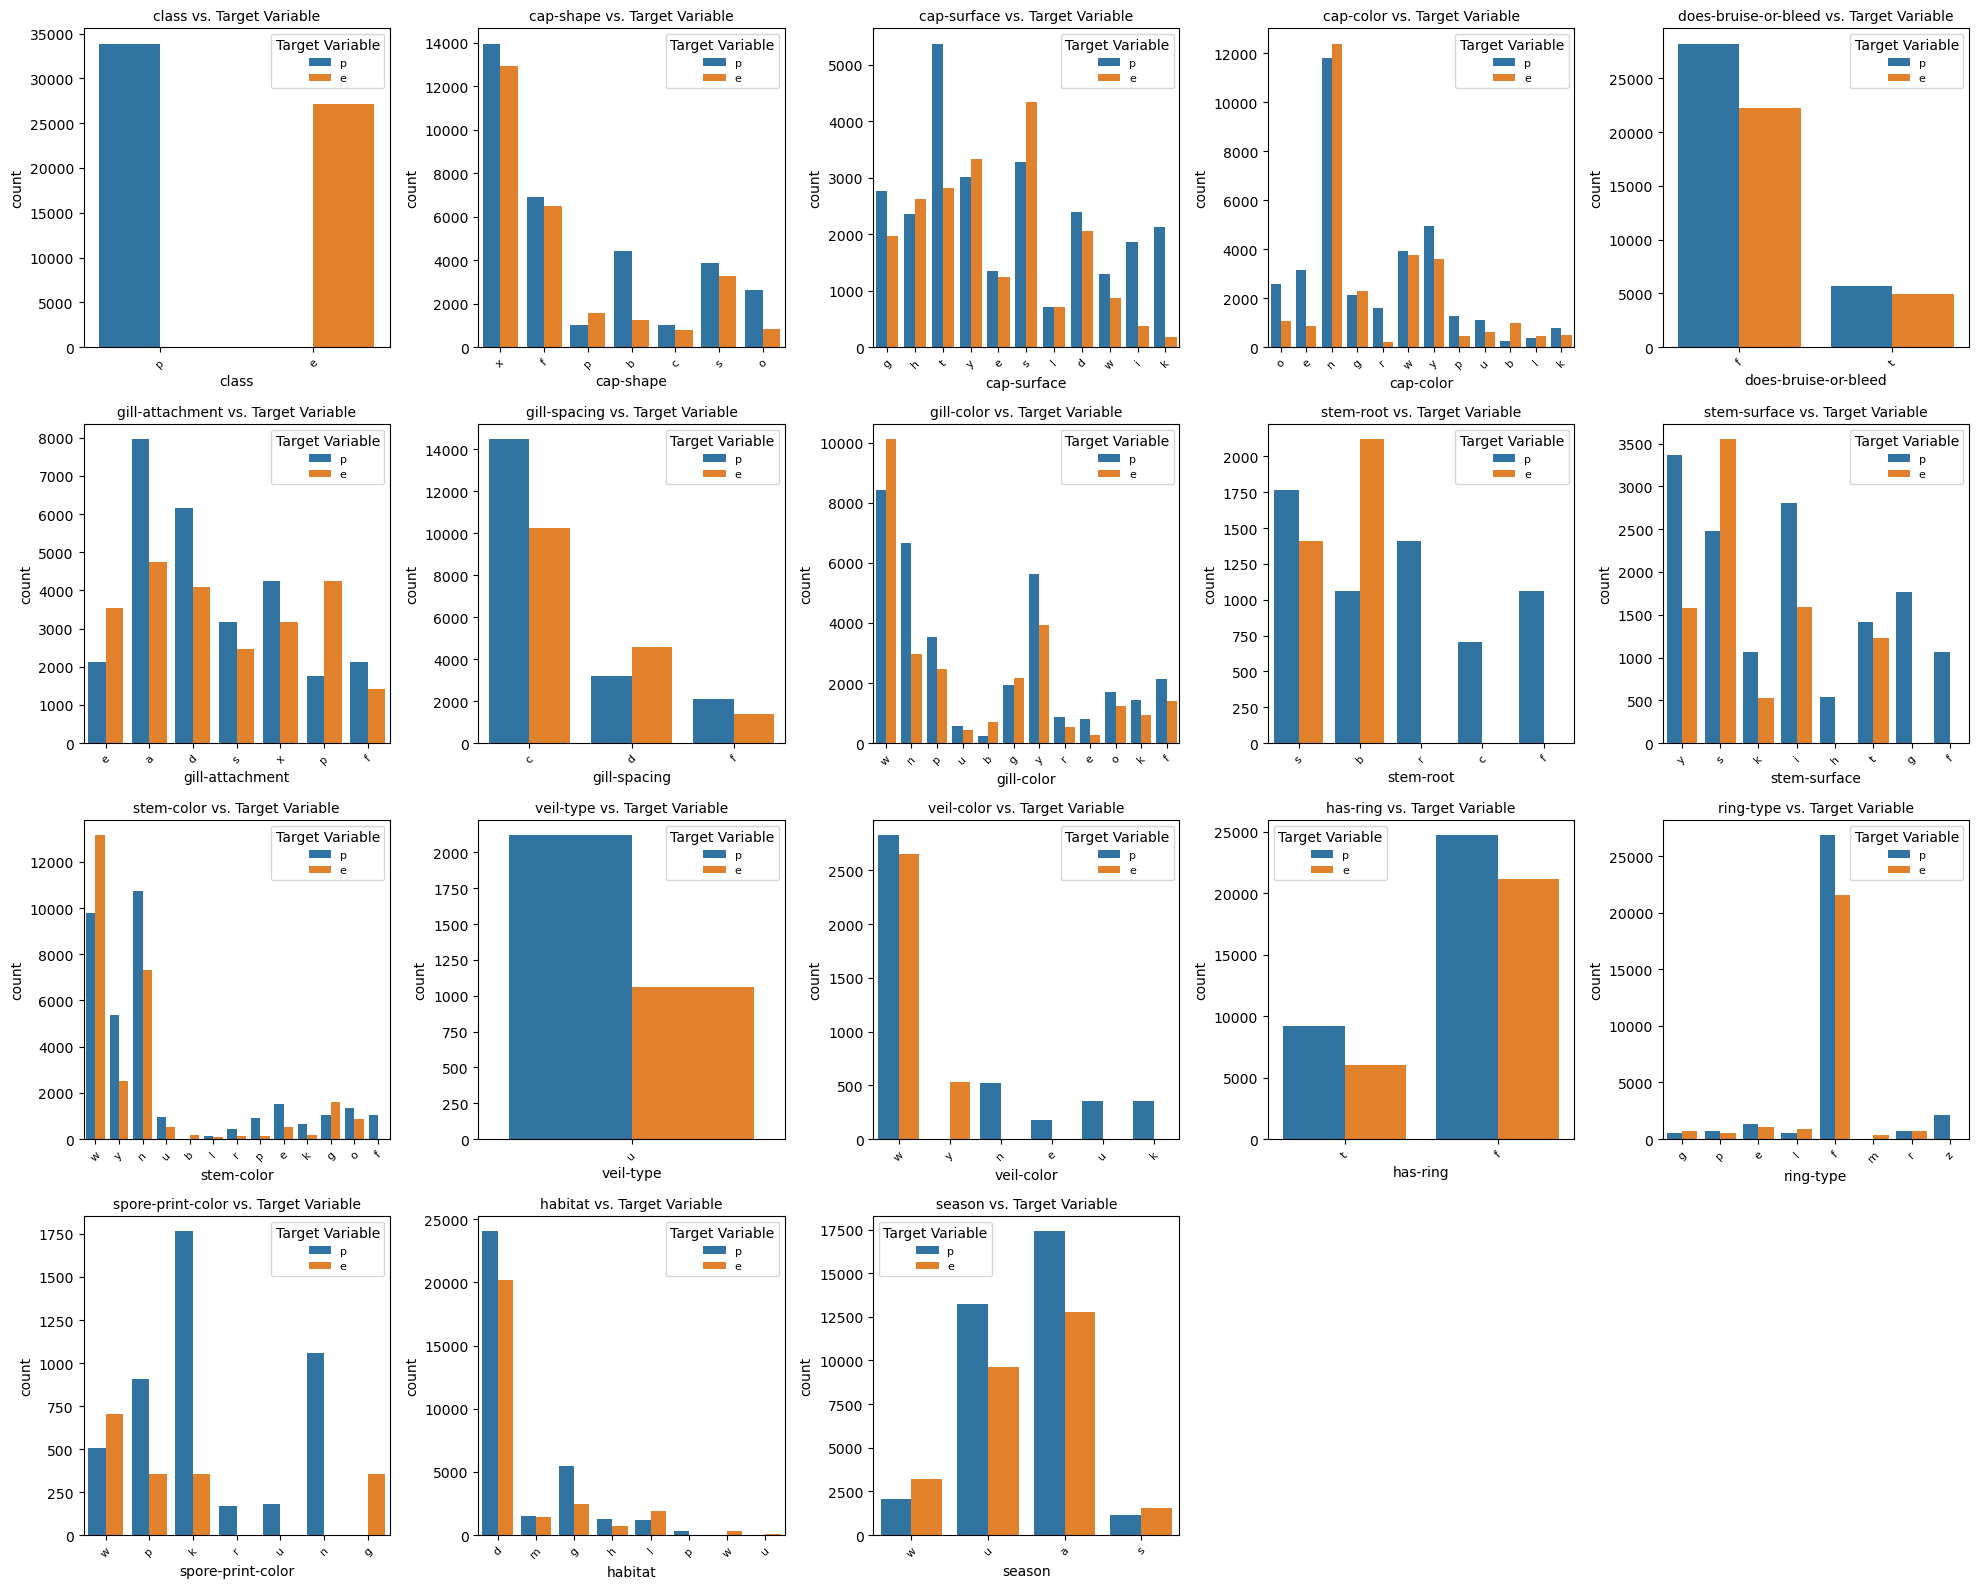

In [49]:
# Explore relationship between categorical features and target variable through bar plot visualisations
# Define the number of rows and columns for the grid
num_rows = 4
num_cols = 5

# Create a figure and an array of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through categorical columns and plot on subplots
categorical_columns = data.select_dtypes(include=['object']).columns
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue='class', data=data, ax=axes[i])
    axes[i].set_title(f'{column} vs. Target Variable', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
    axes[i].legend(title='Target Variable', fontsize=8)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Hide any unused subplots
for i in range(len(categorical_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

# Show the plot
plt.show()

Considering the missing values and the relationships between the features and the target it is reasonable to remove:

*   Veil-type as it ha >90% missing values and there is only a single veil type in the dataset
*   Veil-color as it has >85% missing values and only 1 veil colour encodes information for both the values in the target.
* Spore-print-colour as it has >85% missing values and only 3 out of 7 spore print colours encode data for both the values in the target.
* Stem-root as it has >80% missing values and only 2 out of 5 stem root types encode data for both values in the target

The code chunk below removes these features.

In [50]:
# Drop categorical variables which may bias the prediction
X.drop(columns=['veil-type', 'veil-color', 'spore-print-color', 'stem-root'], inplace=True)

The distribution of the data between edible and poisonous needs to be close to 50/50 in order to prevent bias during training. The following code checks the spread of the data after feature removal.

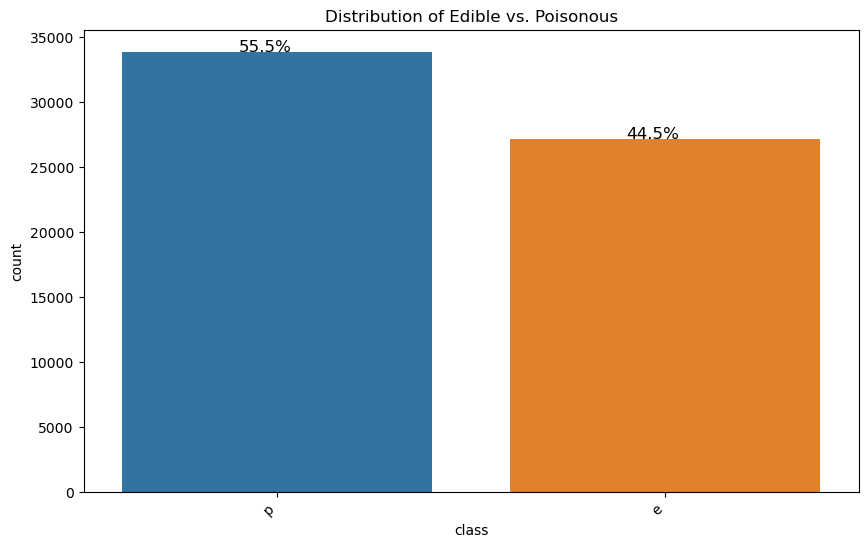

In [51]:
# Check the data spread between edible and poisonous
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='class', data=data)  # Use 'class' column for x-axis
plt.title('Distribution of Edible vs. Poisonous')
plt.xticks(rotation=45, ha='right')

# Calculate percentage for each bar
total = len(data['class'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x_coord = p.get_x() + p.get_width() / 2 - 0.1
    y_coord = p.get_y() + p.get_height()
    ax.annotate(percentage, (x_coord, y_coord), size=12)

plt.show()

### Model creation and training

Machine learning models have certain universal requirements for model training - the data has to be numerical and there needs to be a subset of data for training, validation (in deep learning) and testing. The following code chunk processes the data to make it suitable for the task of training a random forest classifier by using one-hot encoding to assign binary values to the categorical features and creating a 80:20 split in the data for training and testing.

In [52]:
# Encode categorical variables
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Encode target variable (edible=0, poisonous=1)
X_encoded = pd.get_dummies(X)  # One-hot encode categorical features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded,
                                                    test_size=0.2,
                                                    random_state=42)

As a starting point a preliminary random forest model is trained using the training data as is. Then that model can be used to extract the feature importances and a grid search can be done as hyper parameter tuning to find the best model. The following code chunk trains a preliminary model, applies feature selection and then implements a grid search to find the optimal combination of model parameters. The preliminary model is then retrained with the optimised features to give the most accurate prediction model.

Fitting 16 folds for each of 36 candidates, totalling 576 fits


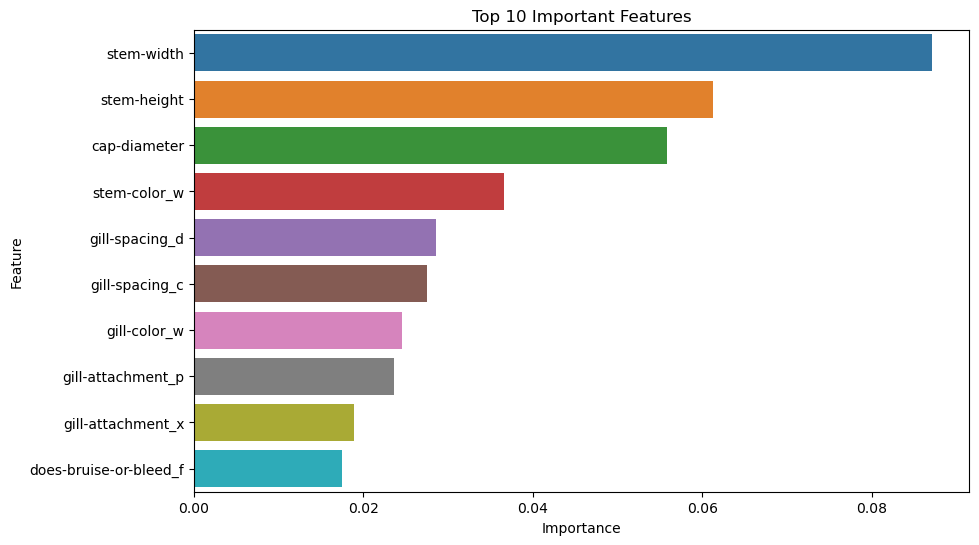

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [53]:
# Train a preliminary RF model to enable feature selection
rf_prelim = RandomForestClassifier(random_state=42)
rf_prelim.fit(X_train, y_train)

# Perform feature selection using feature importance
feature_importances = pd.DataFrame({'Feature': X_encoded.columns,
                                    'Importance': rf_prelim.feature_importances_})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Hyperparameter tuning using GridSearchCV
param_grid = {'n_estimators': [2 ,30, 100],  # the number of trees in the forest
              'max_depth': [1, 10],  # the maximum depth of trees
              'min_samples_split': [2, 3, 5],  # the minimum samples required to split an internal node
              'min_samples_leaf': [1, 2]}   # the minimum samples required to be at a leaf node

# Create a pipeline
grid_search = GridSearchCV(estimator=rf_prelim,
                           param_grid=param_grid,
                           cv=16,   # 16-fold cross-validation
                           scoring='accuracy',  # accuracy as the scoring metric
                           verbose=1)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Important Features')
plt.show()

# Best parameters and model from GridSearchCV
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


The following code chunk saves the best model to the cloned GitHub repository. This file is available in the GitHub repository under Assignment as *best_rf_model.joblib*

|Best Parameters     |        |
|--------------- ----|--------|
|Max Depth           | 10     |
|Max Samples per Leaf| 1      |
|Min samples per split| 2    |
|Number of estimators| 100  |


In [54]:

# Save the best model using joblib
dump(best_rf_model, 'C:/Users/colah/OneDrive/Documents/GitHub/C7082_23381200/Assignment/best_rf_model.joblib')
# replace the file path with the path to the directory where you want to save the model

['C:/Users/colah/OneDrive/Documents/GitHub/C7082_23381200/Assignment/best_rf_model.joblib']

### Results

The classification report indicates that the random forest model performed very well on this theoretical mushroom dataset with an accuracy of 98%. The precision and recall is high for both classes showing that the model is able to identify both poisonous and edible mushrooms with minimal false positives or false negatives. The high F-1 scores across both classes indicate a good balance between precision and recall. Even though the dataset is slightly unbalanced the macro and weighted averages show there is consistent performance across classes. 

The ROC curve provides further illustration of how accurate the model's prediction is when considering the steep almost vertical blue line showing the increase in accuracy.

Classification Report:

|              ||Precision||    Recall||  f1-score||   Support||
|--------------||---------||----------||----------||----------||
|           0  ||   0.97  ||    0.98  ||  0.97    ||   5374   ||
|           1  ||   0.98  ||    0.98  ||  0.98    ||   6840   ||
|              ||         ||          ||          ||          ||
|    accuracy  ||         ||          ||  0.98    ||   12214  ||
|   macro avg  ||   0.98  ||   0.98   ||  0.98    ||   12214  ||
|weighted avg  ||   0.98  ||   0.98   ||  0.98    ||   12214  ||

In [55]:
# Evaluate model performance on test set
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5374
           1       0.98      0.98      0.98      6840

    accuracy                           0.98     12214
   macro avg       0.98      0.98      0.98     12214
weighted avg       0.98      0.98      0.98     12214



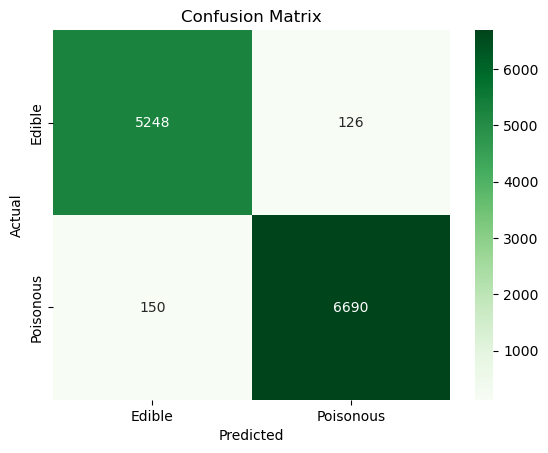

In [56]:
# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Edible', 'Poisonous'], yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.show()
plt.savefig('C:/Users/colah/OneDrive/Documents/GitHub/C7082_23381200/Assignment/Outputs/Confusion_Matrix.png')

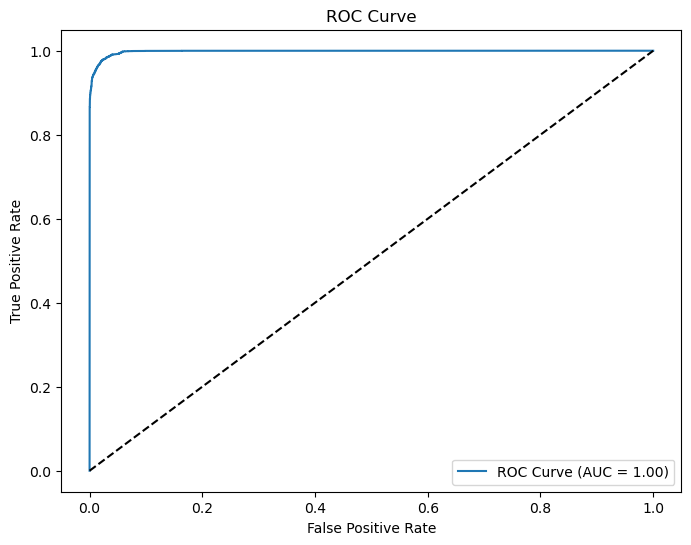

In [57]:
# ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 4. Convolutional Neural Network training


### Methods

#### Data Preparation

The mushroom image dataset was downloaded from kaggle and two folders 'deadly' and 'conditionally_edible' were deleted manually as they are superfluous to the current assignment. The edible ad poisonous mushroom images split into training, testing and validation directories using the code in *CNN_dataset_framework.ipynb* located in the Model_training directory.

In summary the data was divided 80:20 into training and testing data, and then the training data was subdivided following the 80:20 rule again yielding a balanced dataset of 1584 training images, 396 validation images and 495 testing images for both edible and poisonous mushrooms.

The mushroom_dataset directory in the C7082 Git contains the image directory structure ready to be used in model training.

In [6]:
# Change the working directory to the cloned repository
os.chdir('C:/Users/colah/OneDrive/Desktop/Clone') # Change the path to the location of the cloned repository


#### Build a basic model

Before building the model the images that will be used need to be transformed from their raw state into a format that can be utilised by the model. The pre-processing of images includes standardisation, noise reduction, feature enhancement, dimensionality reduction and data augmentation. Processing does not only make them suitable for use in the model, but it can improve model performance by reducing the computational load during training.


The following code uses TensorFlow's image preprocessing functions to load, resize, create batches and standardise the mushroom images, preparing them for training a machine learning model. Followed by data augmentation to expand the dataset since the original dataset is quite small.

In [27]:
# Image preprocessing for basic CNN
# Define common parameters
image_size = (224, 224)
batch_size = 32

# Create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/colah/OneDrive/Desktop/Clone/Model_training/mushroom_dataset/train', # replace with the path to the train folder
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['edible', 'poisonous'],
    shuffle=True)

# Normalize pixel values
train_ds=train_ds.map(lambda x, y: (x/255, y))

# Create validation dataset
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/colah/OneDrive/Desktop/Clone/Model_training/mushroom_dataset/valid', # replace with the path to the valid folder
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['edible', 'poisonous'],
    shuffle=False)

# Normalize pixel values
valid_ds=valid_ds.map(lambda x, y: (x/255, y))

# Create test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/colah/OneDrive/Desktop/Clone/Model_training/mushroom_dataset/test', # replace with the path to the test folder
    image_size= image_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['edible', 'poisonous'],
    shuffle=False)

# Data Augmentation with Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    'C:/Users/colah/OneDrive/Desktop/Clone/Model_training/mushroom_dataset/train', # replace with the path to the train folder
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

Found 3168 files belonging to 2 classes.
Found 792 files belonging to 2 classes.
Found 990 files belonging to 2 classes.
Found 3168 images belonging to 2 classes.


The following code chunk implements a Convolutional Neural Network (CNN) with several modern architectural features aimed at binary image classification. 


There are 3 main sections to the model. The first section has a Conv2D layer which learns basic features in the images, and a BatchNormalisation layer with a ReLU activation to help speed up training. The second section of the model has 2 identical blocks with different filters (128 and 64) aimed at extracting the main features. These blocks use a more efficient SeperableConv2D layer and implement residual connections to help alleviate vanishing gradients. There are also MaxPooling layers which reduce dimensionality whilst retaining the important features. The third section of the model has a SeparableConv2D layer to capture high level features, a GlobalAveragePooling2D layer to reduce the spacial dimensions to a single vector, a dropout layer where 25% of neurons are randomly deactivated during training to prevent overfitting and a final Dense layer with a sigmoid activation function which outputs a probability for either edible or poisonous. The sigmoid activation function is used along with the binary cross entropy loss function when the model is compiled which can improve model accuracy.

In [28]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    
    # We specify activation=None so as to return logits
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)


model_basic = make_model(input_shape=image_size + (3,), num_classes=2)


In [31]:
#Train the model
epochs = 100

callbacks = [keras.callbacks.ModelCheckpoint("Best_basic_model.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_accuracy", patience=4, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_accuracy", patience=50, verbose=1, mode = 'max')]

model_basic.compile(optimizer=keras.optimizers.Adam(0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
model_basic = model_basic.fit(train_ds,
                     epochs=epochs,
                     callbacks=callbacks,
                     validation_data=valid_ds)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5442 - loss: 0.6974 - val_accuracy: 0.5063 - val_loss: 2.0155 - learning_rate: 0.1000
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.5452 - loss: 0.6770 - val_accuracy: 0.5202 - val_loss: 0.8506 - learning_rate: 0.1000
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.5426 - loss: 0.6802 - val_accuracy: 0.5758 - val_loss: 0.7215 - learning_rate: 0.1000
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.5490 - loss: 0.6933 - val_accuracy: 0.5581 - val_loss: 0.9437 - learning_rate: 0.1000
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5481 - loss: 0.6828 - val_accuracy: 0.5732 - val_loss: 0.6735 - learning_rate: 0.1000
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5538 - loss: 0.6796 - val_accuracy: 0.5051 - val_loss: 0.8678 - learning_rate: 0.1000
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5621 - loss: 0.6791
Epoc

#### Results

The following code chunk draws the basic CNN model's accuracy and loss curves tho give a visual representation of the training process

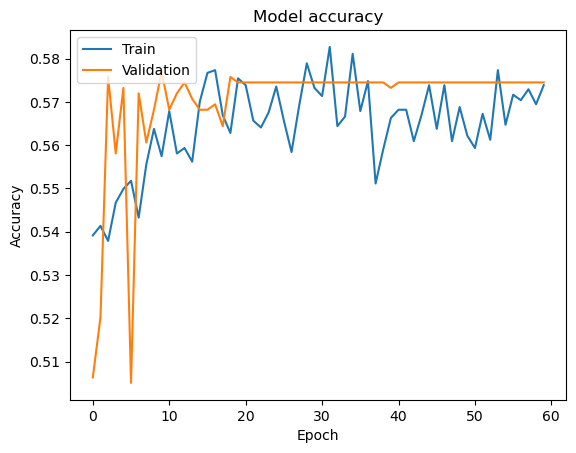

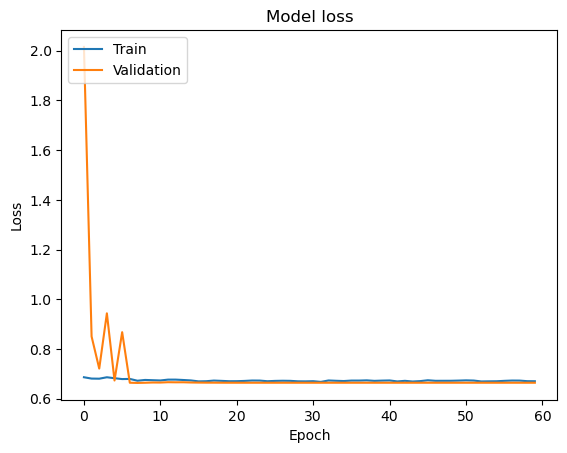

In [35]:
# Plot training & validation accuracy values
plt.plot(model_basic.history['accuracy']) 
plt.plot(model_basic.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_basic.history['loss'])
plt.plot(model_basic.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The basic CNN model does not perform well at the task of classifying mushrooms as edible or poisonous with the best training accuracy being 0.58 (58%) and validation accuracy being 0.5745 (57.45%) at epoch 31. These are only marginally better than a guess.

These results have led on to using transfer learning in an attempt to improve the prediction accuracy of a CNN for mushroom classification.

#### Transfer learning with MobileNet2

Transfer learning is a commonly used machine learning technique where a model developed for one task is used as the starting point for a different, but related task. By using the pretrained model as a base whe training a model for a related task you can utilise the learned features and patterns that have been acquired while solving the original problem and apply them to a new context, significantly reducing the amount of training data and computational resources required. The pre-trained model's learned representations often capture universal features that are valuable across similar domains.


MobileNetV2 is a lightweight convolutional neural network architecture specifically designed for mobile and edge devices. The model achieves high accuracy while maintaining computational efficiency through the use of depthwise separable convolutions and linear bottlenecks. These characteristics make MobileNetV2 particularly suitable for transfer learning in image classification tasks because its architecture efficiently captures hierarchical visual features - from simple edges and textures in early layers to more complex object parts in deeper layers - while maintaining a relatively small parameter count. This means it is possible to fine-tune the model on new datasets without excessive computational costs.

The following code chunk preprosses the data ready for training on the MobileNetV2 model.

In [42]:
# Define common parameters
image_size = (224, 224)
batch_size = 12

# Preprocessing for MobileNetV2
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # Convert to float32
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Apply MobileNetV2 preprocessing
    return image, label

# Create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/colah/OneDrive/Desktop/Clone/Model_training/mushroom_dataset/train', # replace with the path to the train folder
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['edible', 'poisonous'],
    shuffle=True)

# Create validation dataset
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/colah/OneDrive/Desktop/Clone/Model_training/mushroom_dataset/valid', # replace with the path to the valid folder
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['edible', 'poisonous'],
    shuffle=False)

# Create test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/colah/OneDrive/Desktop/Clone/Model_training/mushroom_dataset/test', # replace with the path to the test folder
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    class_names=['edible', 'poisonous'],
    shuffle=False)

# Apply MobileNetV2 preprocessing to datasets
train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# Data Augmentation with Keras ImageDataGenerator for the training and validation datasets
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    'C:/Users/colah/OneDrive/Desktop/Clone/Model_training/mushroom_dataset/train', # replace with the path to the train folder
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

valid_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_generator = valid_datagen.flow_from_directory(
    'C:/Users/colah/OneDrive/Desktop/Clone/Model_training/mushroom_dataset/valid', # replace with the path to the valid folder
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

Found 3168 files belonging to 2 classes.
Found 792 files belonging to 2 classes.
Found 990 files belonging to 2 classes.
Found 3168 images belonging to 2 classes.
Found 792 images belonging to 2 classes.


The code chunk below creates the base model ready for transfer learning. MobileNetV2 requires an input shape of (224,224,4) which is why it is defined in the code.

In [43]:

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2 

EPOCHS = 50 

# Create the base model
base_model = keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet"
)

# Freeze the base model
base_model.trainable = False


# Create the new model
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [keras.callbacks.ModelCheckpoint("Best_trasf_model.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_accuracy", patience=4, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_accuracy", patience=50, verbose=1, mode = 'max')]


In [44]:

# Train the model
history = model.fit(
    train_ds,
    steps_per_epoch=len(train_ds) // batch_size,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_ds,
    validation_steps=len(valid_ds) // batch_size,) 

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.5078 - loss: 0.7464 - val_accuracy: 0.4833 - val_loss: 0.8002 - learning_rate: 1.0000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5447 - loss: 0.6770 - val_accuracy: 0.5833 - val_loss: 0.6369 - learning_rate: 1.0000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5907 - loss: 0.6956 - val_accuracy: 0.3500 - val_loss: 0.8757 - learning_rate: 1.0000e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6566 - loss: 0.6332 - val_accuracy: 0.6333 - val_loss: 0.6491 - learning_rate: 1.0000e-04
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.6527 - loss: 0.6451 - val_accuracy: 0.5667 - val_loss: 0.7711 - learning_rate: 1.0000e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6284 - loss: 0.6354 - val_accuracy: 0.7667 - val_loss: 0.4668 - learning_rate: 1.0000e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 

c:\Users\colah\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6000 - val_loss: 0.6721 - learning_rate: 1.0000e-04
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7618 - loss: 0.5109 - val_accuracy: 0.5833 - val_loss: 0.6336 - learning_rate: 1.0000e-05
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6857 - loss: 0.5590 - val_accuracy: 0.6167 - val_loss: 0.6160 - learning_rate: 1.0000e-05
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.7286 - loss: 0.5545 - val_accuracy: 0.5667 - val_loss: 0.6599 - learning_rate: 1.0000e-05
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7141 - loss: 0.5469
Epoch 17: ReduceLROnPlateau reducing learning rate to 1e-06.
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.7143 - loss: 0.5469 - val_accuracy: 0.5833 - val_loss: 0.6156 - learning_rate: 1.0000e-05
Epoch 1

### Results
The following code chunk draws the basic CNN model's accuracy and loss curves that give a visual representation of the training process

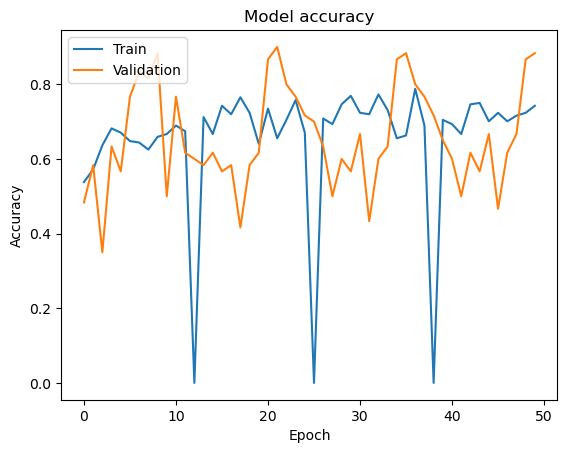

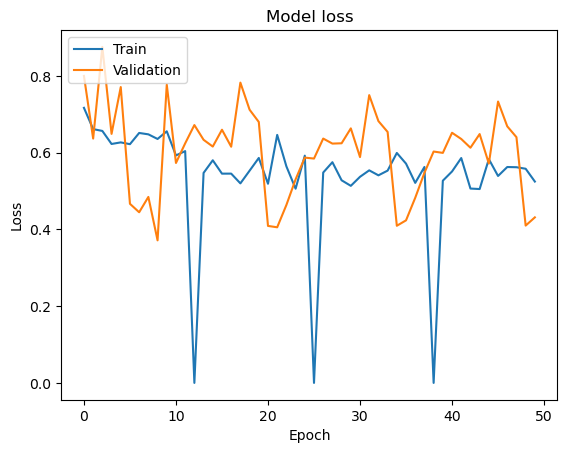

In [45]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The tansfer learning based model performs better on the classification task in half the number of epochs (50 vs 100) but with the best training accuracy of 0.7607 (76.07%) and validation accuracy of 0.8833 (88.33%) reached at epoch 50 this model shows promise but is not yet suitable for practical use.

Using other pretrained models such as VGG16 or InceptionV3 as a base might improve the accuracy making the deployment of this type of tool more realistic.

There is also a need for a database of more images as even with the image generator function in place the model still runs into an error where there is not enough input data and increasing the primary database of images will help alleviate this problem.

# D. Discussion




Different types of data about mushroom characteristics and their edibility exist in various formats across scientific literature, field guides, and digital repositories. While traditional taxonomic data is often structured in tabular format, capturing features like cap size, stem characteristics, and spore colour, there is also a wealth of visual information available as images. Modern machine learning approaches can leverage both these data sources through ensemble or deep learning techniques. By using both approaches the system can benefit from the strengths of each data format - the precision of measured attributes in tabular data and the rich contextual information present in images - potentially leading to more robust and accurate predictions of mushroom edibility than would be possible using either data type alone.

In conclusion, this investigation of machine learning approaches for mushroom classification provides context for the development of mutliple machine learning appraoches as steps toward supporting the growing commercial mushroom industry, while highlighting important limitations. Although the random forest classifier demonstrated high accuracy using tabular data, and the convolutional neural network shows potential for image-based classification, neither approach is currently suitable for autonomous deployment. Instead, these methods could be developed in parallel and potentially combined to create a preliminary screening tool to support experts in mushroom identification. This kind of hybrid approach, when used alongside specialist verification, could help address the mycophobia noted by De Cianni et al. (2023) by providing an additional layer of safety verification in the identification process.

The development of such complementary computational tools becomes increasingly relevant as the mushroom industry expands toward its projected $32.04 million valuation by 2032. Future work should focus on expanding both tabular and image datasets, refining the machine learning architectures, and crucially, investigating how these approaches could be integrated to leverage their respective strengths while maintaining rigorous safety standards. This could eventually enable rapid initial screening of mushrooms, making the rich nutritional and nutraceutical benefits documented by Ma et al. (2018) more accessible, while ensuring safety through mandatory expert verification. There is promise in developing AI-assisted tools that can support specialists in expanding safe access to wild mushrooms' nutritional and therapeutic potential.

# E. Literature


De Cianni, R., Pippinato, L. and Mancuso, T. (2023) 'A systematic review on drivers influencing consumption of edible mushrooms and innovative mushroom-containing products', Appetite, 182, pp. 106454. doi: 10.1016/j.appet.2023.106454.

Kuno-Williams, D. (2022) Mushrooms. Available at: https://www.kaggle.com/datasets/derekkunowilliams/mushrooms/data?select=mushroom_dataset (Accessed: 2024-12-08).

Fortune Business Insights (2024) Mushroom Market Size, Share & Industry Analysis, By Type (Button, Shiitake, Oyster, and Others), By Form (Fresh, Frozen, Dried, and Canned), and Regional Forecast, 2024-2032. Available at: https://www.fortunebusinessinsights.com/industry-reports/infographics/mushroom-market-100197 (Accessed: 2024/12/05).

Ma, G., Yang, W., Zhao, L., Pei, F., Fang, D. and Hu, Q. (2018) 'A critical review on the health promoting effects of mushrooms nutraceuticals', Food Science and Human Wellness, 7(2), pp. 125–133. doi: 10.1016/j.fshw.2018.05.002.

Rawat, W. and Wang, Z. (2017) 'Deep Convolutional Neural Networks for Image Classification: A Comprehensive Review', Neural Computation, 29(9), pp. 2352–2449. doi: 10.1162/neco_a_00990.

Wagner, D., Heider, D. and Hattab, G. (2021a) 'Secondary Mushroom', UCI Machine Learning Repository, 2021. [Online]. Available: https://doi.org/10.24432/C5FP5Q. (Accessed: 2024/12/05)

Wagner, D., Heider, D. and Hattab, G. (2021b) 'Mushroom data creation, curation, and simulation to support classification tasks', Scientific Reports, 11(1), pp. 8134. doi: 10.1038/s41598-021-87602-3.


